In [28]:
from salad.serialize import read, write
from salad.analysis.plot import plot_cluster, plot_result, plot_fake, plot_catalog
import astropy.table
import os
from functools import lru_cache
import matplotlib.pyplot as plt

In [18]:
def load_recovery(pg, detector, snr):
    search_path = f"../search/new_pipeline/DEEP/{pg}/detector_{detector}/snr_{snr}/unshuffled"
    
    catalog = read(os.path.join(search_path, "..", "catalog.pkl"))
    recovery = read(os.path.join(search_path, "recovery.pkl"))
    catalog_findable = read(os.path.join(search_path, "catalog_detectable.pkl"))
    search_findable = read(os.path.join(search_path, "search_detectable.pkl"))
    detector_fakes = read(os.path.join(search_path, "..", "..", "fakes.pkl"))
    clusters = read(os.path.join(search_path, "refined_clusters_2.pkl"))
    
    return catalog, detector_fakes, recovery, catalog_findable, search_findable, clusters

load_recovery("20190403/A0c", 1, 5.0)

(<salad.catalog.MultiEpochDetectionCatalog at 0x7faca72ba590>,
 <Table length=645>
          RA                 DEC         EXPNUM ...        MAG           type  
       float64             float64       int32  ...      float64         str8  
 ------------------- ------------------- ------ ... ------------------ --------
 -143.78459579808396  -11.00317051760483 845872 ...   24.2012042804041 asteroid
 -143.76018180318084 -11.057866904456185 845872 ...  22.42943705005781 asteroid
 -143.78870440533805 -11.113789221728798 845872 ...  26.39768282519579 asteroid
 -143.94902756828535 -11.024494372000278 845872 ... 23.799304654954085 asteroid
 -143.72131260415418 -11.039067138719107 845872 ... 25.519660320084146 asteroid
  -143.9737486197025 -11.023316132846931 845872 ... 21.755897962503614 asteroid
 -143.97400325772028 -11.023055741795972 845873 ... 21.755413035974545 asteroid
 -143.72157089683193 -11.039062789623676 845873 ...  25.51947603816209 asteroid
 -143.78894876644281 -11.113784251107

In [60]:
@lru_cache(maxsize=1024)
def _completeness(pointing_group, snr, detector):
    detector_catalog, detector_fakes, recovery, catalog_findable, search_findable, clusters = load_recovery(
        pointing_group, detector, snr
    )

    did_find = {
        orbit: any([v/catalog_findable[orbit] > 0.6 for k, v in recovery[orbit].items()]) for orbit in recovery
    }
    c = []
    for orbit in did_find:
        c.append(
            dict(
                orbit=orbit,
                detector=detector,
                mag=detector_fakes[detector_fakes['ORBITID'] == orbit][0]['MAG'],
                found=did_find[orbit],
                catalog_possible=catalog_findable[orbit] > 25,
                search_possible=search_findable[orbit]['findable']
            )
        )
    c = astropy.table.Table(c)
    return c
    

def completeness(pointing_group, snr, detectors=list(range(1, 63))):
    c = []
    for detector in detectors:
        try:
            c.extend(_completeness(pointing_group, snr, detector))
        except (FileNotFoundError, EOFError) as e:
            print(pointing_group, detector, snr, e)
            continue

    c = astropy.table.vstack(c)
    return c


completeness("20190403/A0c", 5.0, detectors=[1, 3, 4, 5, 6, 7])

orbit,detector,mag,found,catalog_possible,search_possible
int64,int64,float64,bool,bool,bool
10041343,1,22.42943705005781,False,True,False
10053463,1,25.519660320084146,False,False,True
10564514,1,26.041395418882704,False,False,True
13039521,1,26.39768282519579,False,False,True
13776855,1,23.799304654954085,True,True,True
14621325,1,21.755897962503614,True,True,True
14813564,1,24.2012042804041,False,False,False
10464147,3,20.502337067556955,True,True,True
11697512,3,24.02608431377821,False,False,True


In [63]:
completeness("20190403/A0c", 5.0)

20190403/A0c 2 5.0 Ran out of input
20190403/A0c 22 5.0 Ran out of input
20190403/A0c 30 5.0 [Errno 2] No such file or directory: '../search/new_pipeline/DEEP/20190403/A0c/detector_30/snr_5.0/unshuffled/recovery.pkl'
20190403/A0c 32 5.0 Ran out of input
20190403/A0c 55 5.0 Ran out of input
20190403/A0c 61 5.0 Ran out of input


orbit,detector,mag,found,catalog_possible,search_possible
int64,int64,float64,bool,bool,bool
10041343,1,22.42943705005781,False,True,False
10053463,1,25.519660320084146,False,False,True
10564514,1,26.041395418882704,False,False,True
13039521,1,26.39768282519579,False,False,True
13776855,1,23.799304654954085,True,True,True
14621325,1,21.755897962503614,True,True,True
14813564,1,24.2012042804041,False,False,False
10464147,3,20.502337067556955,True,True,True
11697512,3,24.02608431377821,False,False,True


In [75]:
def bin_detection(catalog, min_mag, max_mag, dm=0.5, min_visits=10):
    fraction_recovered = []
    i = 0
    m = min_mag
    mag = []
    lower = min_mag
    errors = []
    while lower < max_mag:
        lower = min_mag + i * dm
        upper = min_mag + (i + 1) * dm
        a = catalog[(catalog['mag'] >= lower) & (catalog['mag'] < upper)]
        if len(a) > 0:
            num_recovered = a['found'].sum()
            num_possible = len(a)#a['catalog_possible'].sum()
            
            fraction_recovered.append(num_recovered/num_possible)
            mag.append((upper + lower) / 2)
            # num_recovered / num_total
            # sqrt(dx^2 + dy^2)
            errors.append((num_recovered**0.5)/num_possible)
#             errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)

        i += 1

    return mag, fraction_recovered, errors

from scipy.optimize import minimize, curve_fit
import numpy as np
from autograd import elementwise_grad as egrad
from autograd import jacobian, hessian
import autograd.numpy as np

def p(m, c, k, m_50):
    return c / (1 + np.exp(k * (m - m_50)))

def log_p(m, c, k, m_50):
    return np.log(c) - np.log(1 + np.exp(k * (m - m_50)))

def p_3(m, c, k1, k2, m_25):
    return p(m, c, k1, m_25) * p(m, 1, k2, m_25)

def log_p_3(m, c, k1, k2, m_25):
    return log_p(m, c, k1, m_25) + log_p(m, 1, k2, m_25)

def log_l(c, k, m_50, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -np.inf
    return np.sum(log_p(recovered_mag, c, k, m_50)) + np.sum(np.log(1 - p(missed_mag, c, k, m_50)))


def log_l_3(c, k1, k2, m_25, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -np.inf
    return (
        np.sum(np.log(p_3(recovered_mag, c, k1, k2, m_25))) + 
        np.sum(np.log(1 - p_3(missed_mag, c, k1, k2, m_25)))
    )

def fit_completeness(recovered_mag, missed_mag, eq=1, **kwargs):
    minimize_kwargs = dict(
        method="Nelder-Mead", 
        options=dict(maxiter=int(1e3))        
    )
    minimize_kwargs.update(kwargs)
    if eq == 1:
        log_likelihood = log_l
        init_x = np.array(minimize_kwargs.pop("init_x", [0.8, 1, 24]))
    else:
        log_likelihood = log_l_3
        init_x = np.array(minimize_kwargs.pop("init_x", [0.8, 1, 1, 24]))
    
    f = lambda x : -log_likelihood(*x, recovered_mag, missed_mag)
    df = egrad(f)
    jac = jacobian(f)
    hess = hessian(f)
    
    if minimize_kwargs['method'] != "Nelder-Mead":
        minimize_kwargs['jac'] = jac
        minimize_kwargs['hess'] = hess
    opt_result = minimize(f, init_x, **minimize_kwargs)
        
    return opt_result, hess(opt_result.x)


def do_fit(results):
    recovered_mag = results[results['found']]['mag'].value
    missed_mag = results[~results['found']]['mag'].value

    opt_result, hess = fit_completeness(recovered_mag, missed_mag, eq=1)

    d = None
    if opt_result.success:
        best_fit = opt_result.x
        if hess is not None:
            fit_std = np.sqrt(np.diag(np.linalg.inv(hess)))
        else:
            fit_std = np.array([np.nan, np.nan, np.nan])
        d = {
            "c": best_fit[0],
            "k": best_fit[1],
            "m_50": best_fit[2],
            "sigma_c": fit_std[0],
            "sigma_k": fit_std[1],
            "sigma_m_50": fit_std[2],
        }

    return d


In [76]:
d = []

for snr in [5.0, 4.5, 4.0, 3.5, 3.0]:
    c = completeness("20190403/A0c", snr)
    c['snr'] = snr
    d.append(c)
    
pg_c = astropy.table.vstack(d)

20190403/A0c 2 5.0 Ran out of input
20190403/A0c 22 5.0 Ran out of input
20190403/A0c 30 5.0 [Errno 2] No such file or directory: '../search/new_pipeline/DEEP/20190403/A0c/detector_30/snr_5.0/unshuffled/recovery.pkl'
20190403/A0c 32 5.0 Ran out of input
20190403/A0c 55 5.0 Ran out of input
20190403/A0c 61 5.0 Ran out of input
20190403/A0c 2 4.5 Ran out of input
20190403/A0c 22 4.5 Ran out of input
20190403/A0c 32 4.5 Ran out of input
20190403/A0c 55 4.5 Ran out of input
20190403/A0c 61 4.5 Ran out of input
20190403/A0c 2 4.0 Ran out of input
20190403/A0c 22 4.0 Ran out of input
20190403/A0c 32 4.0 Ran out of input
20190403/A0c 55 4.0 Ran out of input
20190403/A0c 61 4.0 Ran out of input
20190403/A0c 2 3.5 Ran out of input
20190403/A0c 22 3.5 Ran out of input
20190403/A0c 30 3.5 [Errno 2] No such file or directory: '../search/new_pipeline/DEEP/20190403/A0c/detector_30/snr_3.5/unshuffled/recovery.pkl'
20190403/A0c 32 3.5 Ran out of input
20190403/A0c 55 3.5 Ran out of input
20190403/A0c 

In [77]:
fits = []
for c in pg_c.group_by("snr").groups:
#     c = c[c['search_possible']]
    f = do_fit(c)
    f['snr'] = c[0]['snr']
    fits.append(f)
    
fits = astropy.table.Table(fits)
fits

c,k,m_50,sigma_c,sigma_k,sigma_m_50,snr
float64,float64,float64,float64,float64,float64,float64
0.8034351469864547,4.323095117510434,24.823319149229015,0.029938938803974087,0.774339560509173,0.07481095614185349,3.0
0.8065383340053148,6.89779285290257,24.46846446175325,0.03001867064851909,1.3783758669458916,0.060049570640675065,3.5
0.8128654856174125,6.239434323559344,24.25347648875365,0.030324788792652452,1.1114580125236746,0.058008633290825465,4.0
0.7975373587762032,5.922709032246474,24.236442585650543,0.03171797395330209,1.0702817143613936,0.06074093487214945,4.5
0.771653683163954,6.699744443415772,24.091638308726615,0.03468303358271246,1.4168253662125985,0.056204606733752195,5.0


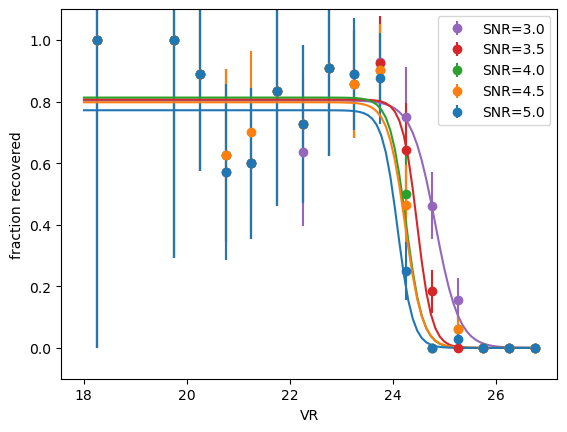

In [78]:
_x = np.linspace(pg_c['mag'].min(), pg_c['mag'].max(), 100)

for c in pg_c.group_by("snr").groups:
    snr = c[0]['snr']
    c = c[c['search_possible']]
#     if snr != 5.0:
#         continue
    x, y, yerr = bin_detection(c, _x.min(), _x.max())
#     plt.scatter(c['mag'], c['found'], label=f"SNR={snr}")
    plt.errorbar(x, y, yerr=yerr, fmt='o', label=f"SNR={snr}", color=f"C{int(-snr*2+10)}")
    
for fit in fits:
    snr = fit['snr']
    plt.plot(_x, p(_x, fit['c'], fit['k'], fit['m_50']), color=f"C{int(-snr*2+10)}")
    
plt.ylim(-0.1, 1.1)
plt.legend()
plt.xlabel("VR")
plt.ylabel("fraction recovered")
plt.show()

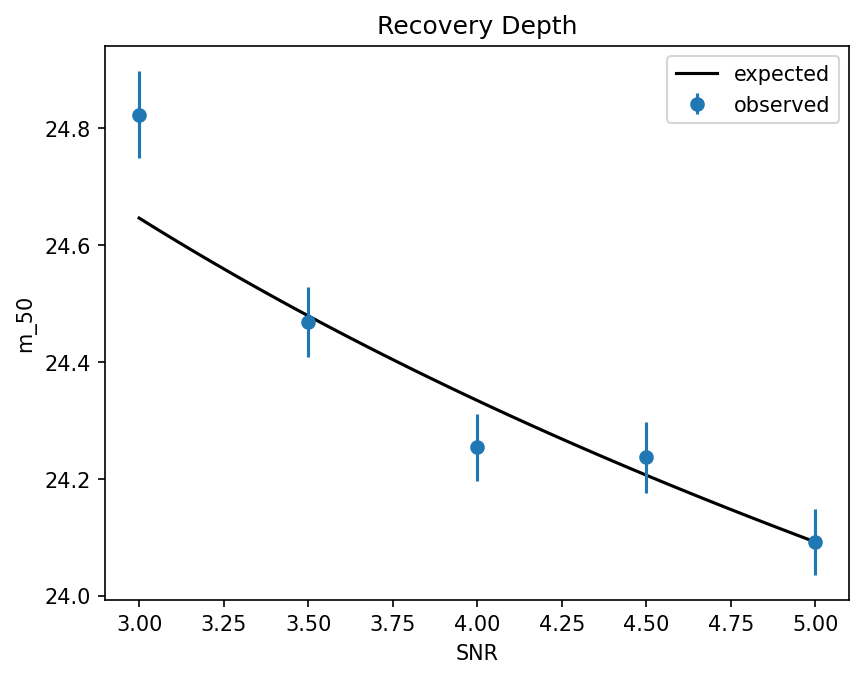

In [67]:
snrs = list(set(fits['snr']))
half_mag = [fits[fits['snr'] == snr]['m_50'][0] for snr in snrs]
half_mag_err = [fits[fits['snr'] == snr]['sigma_m_50'][0] for snr in snrs]
_snrs = np.linspace(min(snrs), max(snrs), 100)
expected = -5/2*np.log10(_snrs/max(snrs)) + half_mag[snrs.index(max(snrs))]

fig = plt.figure(dpi=150, facecolor="white")
plt.plot(_snrs, expected, label="expected", c='k')
plt.errorbar(snrs, half_mag, yerr=half_mag_err, fmt="o", label="observed")
plt.xlabel("SNR")
plt.ylabel("m_50")
plt.legend()
plt.title("Recovery Depth")
plt.show()